# OpSim -- the updated simulation notebook

## About

This notebook is for testing of the OpSim functionality.
Data is read from prefabricated files containing the Sun and the two Satellites' positions as time series. The data is stored and read in the HDF5 format.

In [1]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility ---
import  os, sys

import  numpy as np
import  yaml
import  matplotlib.pyplot as plt
import  simpy

# ---------------------------------------------------------
import  lusee        # Core lusee software
import  nav          # Astro/observation wrapper classes
from    nav import *
from    utils.timeconv import *

import  sim          # Main simulation handler
from    sim import Simulator

#import  hardware     # hardware modules


print("---------------------------------- PATH ----------------------------------------")
for path_part in sys.path:
    if path_part!='': print(f'''{path_part}''')



print('--------------------------------- VERSIONS -------------------------------------')
print(f'''simpy: {simpy.__version__}, lusee: {lusee.__version__}, sim: {sim.__version__}''')

---------------------------------- PATH ----------------------------------------
/home/maxim/projects/lusee/opsim/notebooks
/home/maxim/projects/lusee/luseepy
/home/maxim/projects/lusee/opsim
/home/maxim/.virtualenvs/lusee/lib/python3.10/site-packages/backports
/usr/local/lib/python310.zip
/usr/local/lib/python3.10
/usr/local/lib/python3.10/lib-dynload
/home/maxim/.virtualenvs/lusee-simpy/lib/python3.10/site-packages
--------------------------------- VERSIONS -------------------------------------
simpy: 4.0.2, lusee: 1.2-dev, sim: 0.1


In [3]:
orbitals    = "../data/20250204-20250807.hdf5"
modes       = "../config/modes.yml"
devices     = "../config/devices.yml"
comtable    = "../config/comtable-20250204-20250807-new.yml"

In [4]:
smltr = Simulator(orbitals, modes, devices, comtable, initial_time=1548, until=11465)

Shape of the data payload: (17760, 7)
Created a Battery with initial charge: 100.0, capacity: 1200.0


In [5]:
# OPTIONAL
smltr.info()

Orbitals file: ../data/20250204-20250807.hdf5
------------------
Modes file: ../config/modes.yml
science
	spectrometer
		SCIENCE
	comms
		OFF
	bms
		OFF
	controller
		ON
charge
	spectrometer
		OFF
	comms
		OFF
	bms
		ON
	controller
		ON
comms
	spectrometer
		OFF
	comms
		ON
	bms
		ON
	controller
		ON
powersave
	spectrometer
		OFF
	comms
		OFF
	bms
		OFF
	controller
		ON

------------------
Devices file: ../config/devices.yml
------------------
Comtable file: ../config/comtable-20250204-20250807-new.yml
1
	start
		60726.13541667
	mode
		charge
2
	start
		60740.9375
	mode
		powersave
3
	start
		60755.73958333
	mode
		science
4
	start
		60770.45833333
	mode
		powersave



---

### Optional -- some graphs.

Can scroll down to run the sim


In [ ]:
# OPTIONAL


# Get a handle on the sun and the satellite, in case needed for diagnostics
mySun = smltr.sun
mySat = smltr.esa

print(mySun.N)

fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p2.set_xlabel('Time (MJD)')

p1.plot(mySat.mjd, mySat.alt,  color="orange", label="Sat Alt")
p1.plot(mySun.mjd, mySun.alt,  color="blue",   label="Sun Alt")

p2.plot(mySat.mjd, mySat.az, color="magenta",label="Sat Az")
p2.plot(mySun.mjd, mySun.az, color="red",    label="Sun Az")


p1.grid(True)
_ = p1.legend()

p2.grid(True)
_ = p2.legend()


In [ ]:
# OPTIONAL

print(f'''Sunrise: {mySun.sunrise}''')

plt.rcParams["figure.figsize"] = [10., 10.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, smltr.controller.power*100.,  color="red",    label="Panel power*100")
ax.grid(True)


---

### Run the simulation

In [6]:
# smltr.env.process(smltr.run())
smltr.simulate()

1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747


---

### Plot the results

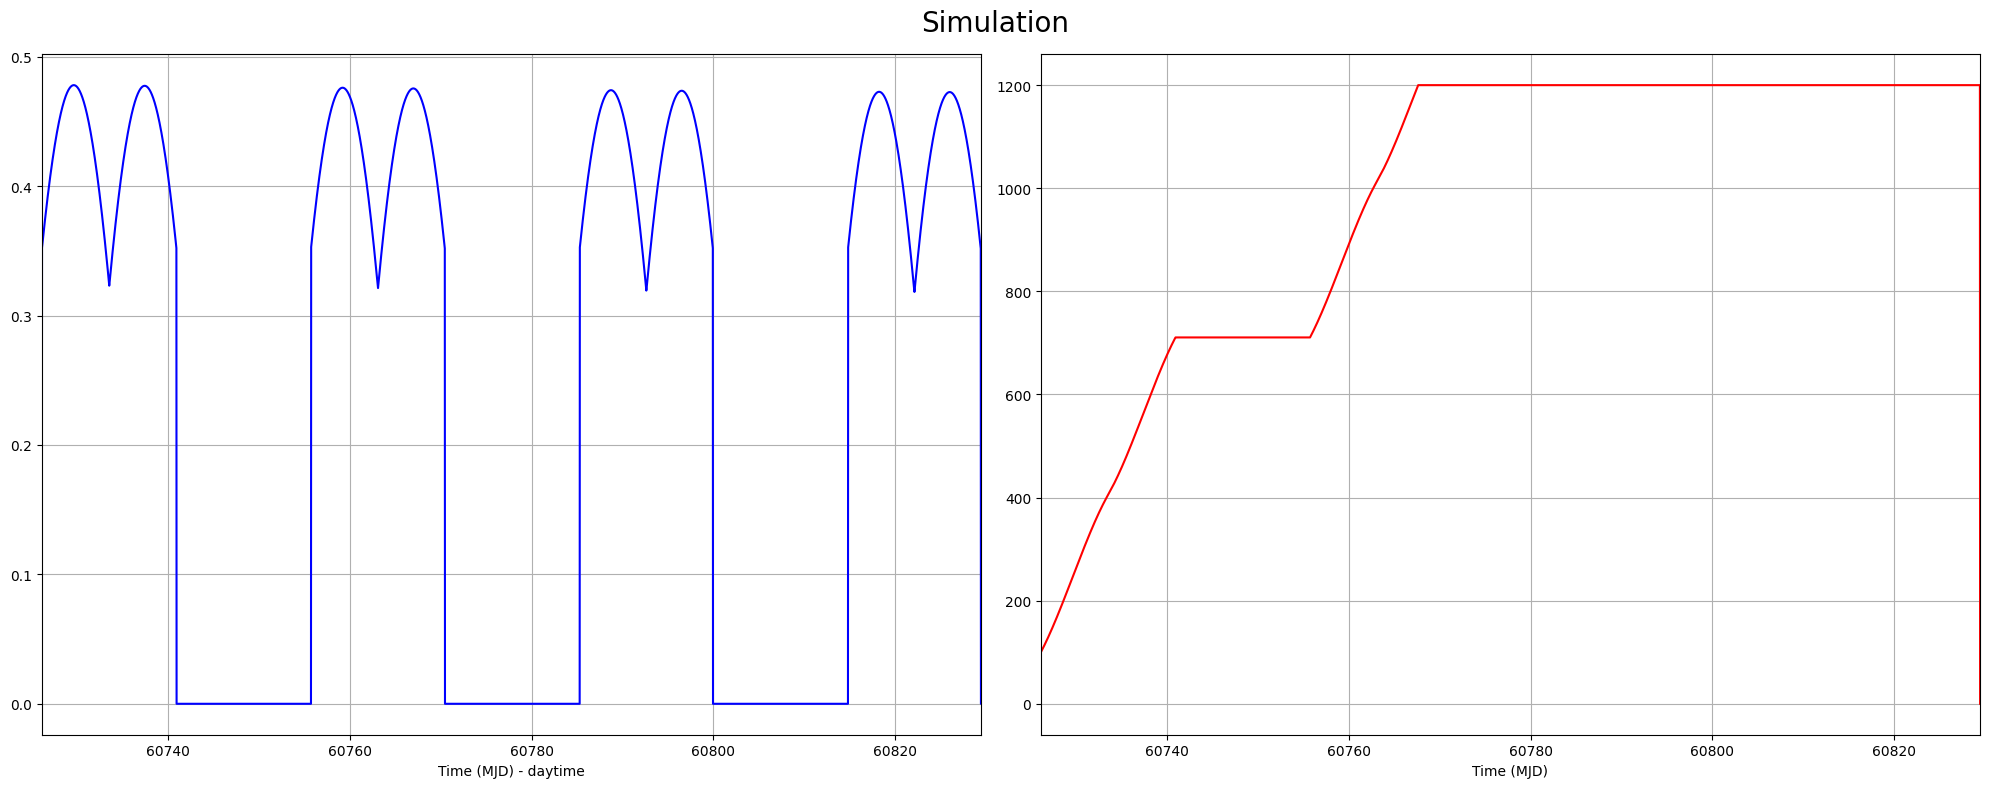

In [9]:
fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD) - daytime')
p2.set_xlabel('Time (MJD)')


mjd = smltr.sun.mjd
p1.plot(mjd, smltr.controller.power,  color="blue",   label="Panel exposure (area units)")
p2.plot(mjd, smltr.monitor.battery, color="red",    label="Panel power (a.u.)")


xlo = mjd[smltr.initial_time]
xhi = mjd[smltr.until]

p1.set_xlim([xlo, xhi])
p2.set_xlim([xlo, xhi])

p1.grid(True)
p2.grid(True)

plt.show()






---

## Archived utilities

Useful bits of code that aren't necesserily executed every time.


In [ ]:
# Pretty print the dictionary we read from the input YAML, for an extra check:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

In [ ]:
print('Current directory:', os.getcwd())

# Define files to configure the run:

conf_flnm   = '../config/conf.yml'
modes_flnm  = '../config/modes.yml'
devices_flnm= '../config/devices.yml'


print(f'''-------------------- {conf_flnm} ---------------------------------------------------''')
conf    = yaml.safe_load(open(conf_flnm, 'r'))
pretty(conf)


print(f'''-------------------- {modes_flnm} ---------------------------------------------------''')
modes   = yaml.safe_load(open(modes_flnm, 'r'))
pretty(modes)


print(f'''-------------------- {devices_flnm} ---------------------------------------------------''')
devices   = yaml.safe_load(open(modes_flnm, 'r'))
pretty(devices)
